<a href="https://colab.research.google.com/github/abhranil-datascience/DeepLearning/blob/ImageAnalytics/Day9_VGG16FromKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
############################################ Mount Drive and make necessary imports ######################################################
from google.colab import drive
drive.mount('/content/gdrive')

############################## Change Directory ###################################
import os
os.chdir('/content/gdrive/My Drive/ImageAnalytics/Day1-CNN/Dataset')

########## Suppress Warnings ############
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#################### Define Constant Folder Names and Get File Paths ###########################
Dataset='/content/gdrive/My Drive/ImageAnalytics/Day1-CNN/Dataset'
TrainingSet='/training_set'
TestSet='/test_set'
TrainingSetPath=Dataset+TrainingSet
TestSetPath=Dataset+TestSet
cat_folder='/cats'
dog_folder='/dogs'
TrainingSetCat=TrainingSetPath+cat_folder
TrainingSetDog=TrainingSetPath+dog_folder
TestSetCat=TestSetPath+cat_folder
TestSetDog=TestSetPath+dog_folder
TrainingSetCatImages=[TrainingSetCat+"/"+path for path in os.listdir(TrainingSetCat) if '.jpg' in path]
TrainingSetDogImages=[TrainingSetDog+"/"+path for path in os.listdir(TrainingSetDog) if '.jpg' in path]
print("Number of Cats in Training Set: "+str(len(TrainingSetCatImages))+" || Number of Dogs in Training Set: "+str(len(TrainingSetDogImages)))
import random
random.shuffle(TrainingSetCatImages)
random.shuffle(TrainingSetDogImages)

Number of Cats in Training Set: 3928 || Number of Dogs in Training Set: 4000


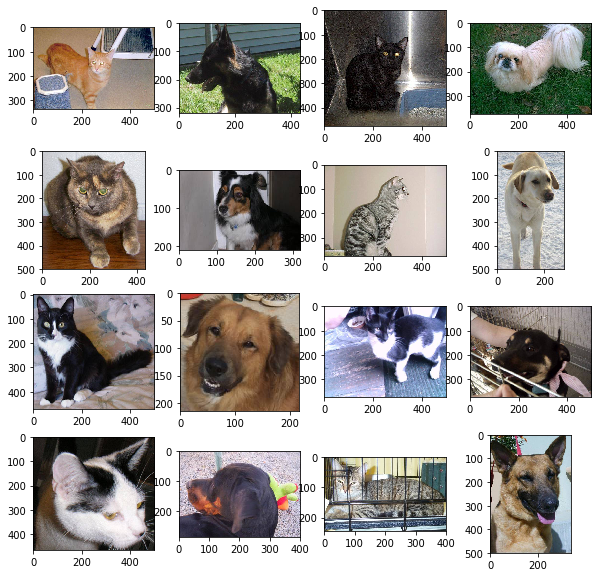

In [0]:
##################################### View Some Cat and Dog Images #####################################
TrainingSetImages=[]
for count in range(0,8):
  TrainingSetImages.append(TrainingSetCatImages[count])
  TrainingSetImages.append(TrainingSetDogImages[count])
import matplotlib.pyplot as plt
import matplotlib.image as mimg
fig=plt.figure(figsize=(10,10))
columns=4
rows=4
for count in range(0,len(TrainingSetImages)):
  curr_img=mimg.imread(TrainingSetImages[count])
  fig.add_subplot(rows,columns,count+1)
  imgplot=plt.imshow(curr_img)
plt.show()

In [0]:
######################################################## Create Image Generator and Preprocess #####################################################################
from keras.preprocessing.image import ImageDataGenerator
TrainImageGenerator=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,vertical_flip=True)
TestImageGenerator=ImageDataGenerator(rescale=1./255)
TrainDataset=TrainImageGenerator.flow_from_directory(directory=TrainingSetPath,target_size=(224,224),batch_size=90,classes=['cats','dogs'],
                                                     class_mode='categorical',shuffle=True)
TestDataset=TestImageGenerator.flow_from_directory(directory=TestSetPath,target_size=(224,224),batch_size=90,classes=['cats','dogs'],
                                                     class_mode='categorical',shuffle=True)
#TrainDataset.class_indices ==> {'cats': 0, 'dogs': 1}
#TestDataset.class_indices ==> {'cats': 0, 'dogs': 1}

Using TensorFlow backend.


Found 7928 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
from keras.layers import Dense,Flatten,Dropout
from keras.models import Model
from keras.applications import vgg16 as vgg
inbuilt_vgg=vgg.VGG16(input_shape=(224,224,3),weights=None,include_top=False)
inbuilt_vgg_flat=Flatten()(inbuilt_vgg.output)
Dense1=Dense(units=4096,activation='relu')(inbuilt_vgg_flat)
#DropoutLayer=Dropout(0.4)(Dense1)
Dense2=Dense(units=4096,activation='relu')(Dense1)
VGGOutput=Dense(units=2,activation='softmax')(Dense2)
vgg_model=Model(inbuilt_vgg.input,VGGOutput)
from keras.optimizers import Adam
adam=Adam(lr=0.00001)
vgg_model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
vgg_model.summary()







Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [6]:
############################################### Train Model and Save Best Model #######################################################
BestModelName='VGG16_BestModel.hdf5'
BestModelDirectoryPath="/content/gdrive/My Drive/ImageAnalytics/Day9-VGG16FromKeras/BestModel/"
BestModelPath=BestModelDirectoryPath+BestModelName
from keras.callbacks import ModelCheckpoint,EarlyStopping
save_best_model=ModelCheckpoint(filepath=BestModelPath,monitor='val_acc',save_best_only=True,mode='max',verbose=2)
early_stop=EarlyStopping(monitor='val_acc',min_delta=0.005,mode='max',restore_best_weights=True,patience=25,verbose=2)
vgg_model_training=vgg_model.fit_generator(generator=TrainDataset,steps_per_epoch=7928/90,epochs=100,callbacks=[save_best_model,early_stop],validation_data=TestDataset,
                                          validation_steps=2000/90,shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
89/88 [==============================] - 279s 3s/step - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6926 - val_acc: 0.5005

Epoch 00001: val_acc improved from -inf to 0.50050, saving model to /content/gdrive/My Drive/ImageAnalytics/Day9-VGG16FromKeras/BestModel/VGG16_BestModel.hdf5
Epoch 2/100
89/88 [==============================] - 250s 3s/step - loss: 0.6910 - acc: 0.5217 - val_loss: 0.6823 - val_acc: 0.5215

Epoch 00002: val_acc improved from 0.50050 to 0.52150, saving model to /content/gdrive/My Drive/ImageAnalytics/Day9-VGG16FromKeras/BestModel/VGG16_BestModel.hdf5
Epoch 3/100
89/88 [==============================] - 251s 3s/step - loss: 0.6679 - acc: 0.5730 - val_loss: 0.6788 - val_acc: 0.5815

Epoch 00003: val_acc improved from 0.52150 to 0.58150, saving model to /content/gdrive/My Drive/ImageAnalytics/Day9-VGG16FromKeras/BestModel/VGG16_BestModel.hdf5
Epoch 4/100
89/88 [====